# KBMod Orbit Fitting

This notebook shows how to get orbit elements from results output by a **KBMOD** search.

## Requirements

* Requires cloning [dirac-institute/pyOrbfit](https://github.com/dirac-institute/pyOrbfit) (our branch of David Gerdes' python wrapper for the Bernstein and Khushalani (2000) orbit fitting code.

* Add the location for the `pyOrbfit` directory to the **KBMOD** `setup.bash` file as `$PYORBFIT_HOME`.

* Source the `setup.bash` file and you're good to go!

## Imports

Here we import tools for getting the data we need from the images and relevant data files. The actual code we use for orbit calculating is found in the `ephem_utils` class in the **KBMOD** codebase.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from ephem_utils import KbmodInfo, OrbitUtils
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Get relevant data

### Data required

* List of visit numbers and visit times in MJD.

* One of the processed images used in the **KBMOD** search so that we can grab the WCS

* List of visits in the search

* **KBMOD** results file

In [2]:
# Arrays of Visit Numbers and Visit Times
visit_df = pd.read_csv('/epyc/users/smotherh/DECAM_Data_Reduction/loriallen_times.dat', delimiter=' ',
                       skiprows=1, names=['visit_num', 'visit_mjd'])

# Image File
image_file = str('/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/'+
                 'Pointing_Group_300/processed_data/rerun/rerun_processed_data/0433932/'+
                 'calexp/calexp-0433932_22.fits')

# List of visits searched
results_visit_list = [433932, 433936, 433940, 433945, 433949,
                      434610, 434614, 434622, 434626, 435498,
                      435502, 435506, 435510, 435514]

# KBMOD results output
results_file = '/epyc/users/smotherh/DECAM_Data_Reduction/kbmod_results/300/22/results_full_lc.txt'

## Load into `ephem_utils`

Take the data and data locations specified above and give them to `ephem_utils`. Also need to specify the observatory code where the data was taken.

In [3]:
# Observatory ID
cerro_tololo_id = '807'

kbmod_info = KbmodInfo(results_file, image_file,
                       visit_df['visit_num'].values, 
                       visit_df['visit_mjd'].values, 
                       results_visit_list, cerro_tololo_id)

The class loads the results file into a pandas dataframe called `results_df`.

In [4]:
kbmod_info.results_df.head()

,lh,flux,x0,y0,x_v,y_v,obs_count
0,51.338379,1167.514038,89.0,4021.0,-58.496994,-207.676514,10.0
1,52.504288,1115.429565,129.0,2667.0,-96.969185,-188.935974,10.0
2,49.810539,1063.618896,76.0,2698.0,-43.673504,-219.940170,10.0
3,49.793983,1077.010132,181.0,2743.0,-148.411545,-265.212677,10.0
4,57.040955,1245.665527,63.0,2597.0,-30.895140,-118.556183,10.0


## Format observations of result

Here we pick the first object in the results file and calculate the (ra, dec) of the observations in the search. We then convert this to output in MPC format that we can use to fit the orbit.

First, `get_searched_radec` takes one of the results from the file and converts the information to (ra, dec) stored in `ep.coords`. Then `format_results_mpc` will take these coordinates and output them into MPC format. By default this will save it to a file called `kbmod_mpc.dat` but another filename can be specified.

In [5]:
results_idx = 0
kbmod_info.get_searched_radec(results_idx)

In [6]:
print(kbmod_info.coords)

<SkyCoord (ICRS): (ra, dec) in deg
    [(200.91787216, -8.04905938), (200.91782246, -8.0490454 ),
     (200.91777294, -8.04903146), (200.9176511 , -8.04899718),
     (200.91760216, -8.04898341), (200.90265766, -8.04477839),
     (200.9026079 , -8.04476439), (200.90250855, -8.04473644),
     (200.9024589 , -8.04472247), (200.87194965, -8.03613891),
     (200.87189798, -8.03612437), (200.87184859, -8.03611048),
     (200.87179874, -8.03609646), (200.87174928, -8.03608254)]>


In [7]:
mpc_results = kbmod_info.format_results_mpc()
mpc_results

['     c111112  c2015 04 18.27432 13 23 40.289-08 02 56.61                     807',
 '     c111112  c2015 04 18.27756 13 23 40.277-08 02 56.56                     807',
 '     c111112  c2015 04 18.28079 13 23 40.266-08 02 56.51                     807',
 '     c111112  c2015 04 18.28873 13 23 40.236-08 02 56.39                     807',
 '     c111112  c2015 04 18.29192 13 23 40.225-08 02 56.34                     807',
 '     c111112  c2015 04 19.26576 13 23 36.638-08 02 41.20                     807',
 '     c111112  c2015 04 19.26900 13 23 36.626-08 02 41.15                     807',
 '     c111112  c2015 04 19.27548 13 23 36.602-08 02 41.05                     807',
 '     c111112  c2015 04 19.27871 13 23 36.590-08 02 41.00                     807',
 '     c111112  c2015 04 21.26671 13 23 29.268-08 02 10.10                     807',
 '     c111112  c2015 04 21.27008 13 23 29.256-08 02 10.05                     807',
 '     c111112  c2015 04 21.27329 13 23 29.244-08 02 10.00       

In [8]:
kbmod_info.save_results_mpc('kbmod_mpc.dat')

## Predict Orbital Elements

Take in the file with the MPC-formatted observations and use the wrapped Bernstein and Khushalani code to get the orbital elements. If no file is specified it will look for the default `kbmod_mpc.dat` filename.

In [9]:
orbit_info = OrbitUtils('kbmod_mpc.dat')

In [10]:
el, err = orbit_info.predict_elements()

In [11]:
el, err

({'a': 57.70900956548056,
  'aop': 171.73073956796844,
  'e': 0.01093420530612745,
  'i': 43.70358203289912,
  'lan': 23.14934213602355,
  'top': 2453964.822886323},
 {'a': 29.632266287657632,
  'aop': 3066.2735919868664,
  'e': 0.579830965340102,
  'i': 21.807547871385676,
  'lan': 0.5514461271059155,
  'top': 1333338.918906526})

## Predict location at other times

### Get coordinates of predictions

Now we can use the code to predict the location of the object at other times. Here we set a date range of 50 days before and after the initial observation in our **KBMOD** search. Then we predict the (ra, dec) for these times before storing them in a pandas dataframe with the time of each predicted location.

In [12]:
date_range = np.arange(kbmod_info.mjd_0-50., kbmod_info.mjd_0+50., 0.5)
pred_ra, pred_dec = orbit_info.predict_ephemeris(date_range)

# Take this data and turn into a pandas dataframe of predicted observational locations and times
ephem_df = pd.DataFrame(np.array([date_range, pred_ra, pred_dec]).T, columns=['mjd', 'pred_ra', 'pred_dec'])
ephem_df.head()

,mjd,pred_ra,pred_dec
0,57080.274322,201.615442,-8.241979
1,57080.774322,201.610128,-8.240658
2,57081.274322,201.604805,-8.239339
3,57081.774322,201.599390,-8.237980
4,57082.274322,201.593965,-8.236623


### Plot predicted locations

We can also take this data range and plot it with the observations from our search highlighted on the orbit.

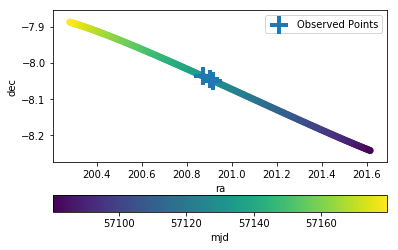

In [13]:
fig = orbit_info.plot_predictions(date_range)

### Get predicted pixel locations in a new image

Take a new image and calculate the predicted pixel locations at given times for the object. Even though we use a single WCS it is useful to get an idea of where an object might be in a sequence of images taken of the same field.

In [14]:
new_image = str('/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/'+
                'Pointing_Group_300/processed_data/rerun/rerun_processed_data/0434610/'+
                'calexp/calexp-0434610_22.fits')

new_times = np.arange(kbmod_info.mjd_0+1, kbmod_info.mjd_0+1.5, 0.1)

x_pix, y_pix = orbit_info.predict_pixels(new_image, new_times)

# Create a pandas dataframe with the predicted x, y locations
pixel_df = pd.DataFrame(np.array([new_times, x_pix, y_pix]).T, columns=['mjd', 'pred_x_loc', 'pred_y_loc'])
pixel_df.head()

,mjd,pred_x_loc,pred_y_loc
0,57131.274322,33.725132,3798.938113
1,57131.374322,27.826228,3777.955707
2,57131.474322,21.919779,3757.163791
3,57131.574322,16.022953,3736.566189
4,57131.674322,10.150093,3716.093801


In [15]:
orbit_obj = orbit_info.get_orbit()

In [16]:
orbit_obj.covar_aei

array([[ 8.78071205e+02,  1.70465049e+01, -1.12713864e+01,
         2.85020374e-01,  1.95448329e+02,  1.34472226e+04],
       [ 1.70465049e+01,  3.36203948e-01, -2.18799547e-01,
         5.53281260e-03, -5.94824722e-02, -1.78446480e+00],
       [-1.12713864e+01, -2.18799547e-01,  1.44866646e-01,
        -3.66323385e-03, -2.53989401e+00, -1.74731679e+02],
       [ 2.85020374e-01,  5.53281260e-03, -3.66323385e-03,
         9.26319736e-05,  6.42173964e-02,  4.41783281e+00],
       [ 1.95448329e+02, -5.94824722e-02, -2.53989401e+00,
         6.42173964e-02,  2.86402326e+03,  1.95361217e+05],
       [ 1.34472226e+04, -1.78446480e+00, -1.74731679e+02,
         4.41783281e+00,  1.95361217e+05,  1.33260262e+07]])

[0.00787499848553212, 0.0025123945330138933, 8.158304709232758e-05, 2.6964149465666414e-07, 0]


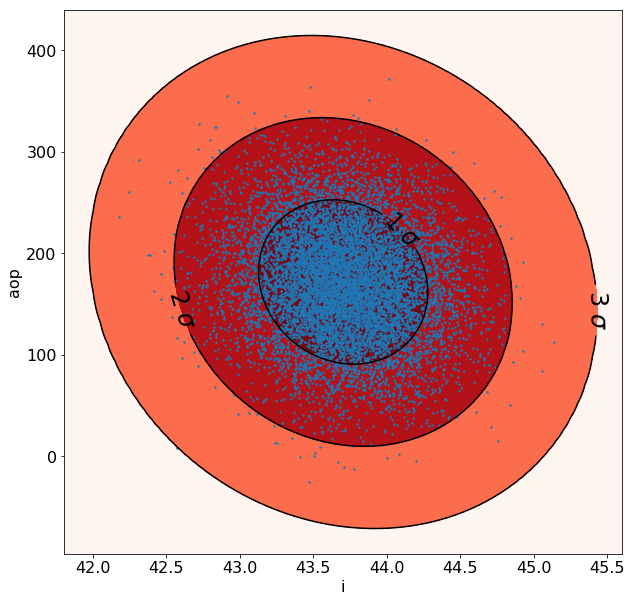

In [74]:
fig = plt.figure(figsize=(10,10))
fig = orbit_info.plot_elements_uncertainty('i', 'aop', fig)